# Часть 1. Нейросетевые рекомендации

В этом задании вам предстоит обучить свою рекомендательную нейросетевую модель для рекомендаций текстовых статей на основе датасета Дзена.

Как обсуждалось на лекции, нередко в нейросетевых рекомендациях используют архитектуры типа DSSM. Предлагается построить и обучить модель именно такого вида.

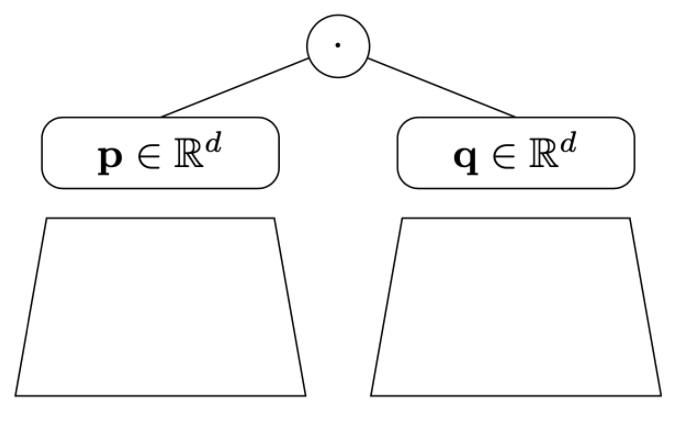


Модель состоит из двух нейросетевых частей:
1. Айтемная. Принимает на вход мешок слов, из которых состоит текст.
2. Пользовательская. Принимает на вход мешок слов из текстов айтемов, которые понравились пользователю.

Обучать такую модель можно на FPS-лосс (Full Product Softmax).

*Замечания:*
1. Приведенная в ноутбуке схема приблизительная, можно предложить свою с пояснениями улучшений.
2. При обучении из пользовательской истории нужно выкидывать айтем, который подаем в айтемную.

In [1]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for youtokentome: filename=youtokentome-1.0.6-cp310-cp310-linux_x86_64.whl size=1927544 sha256=7a08850b8cc0281f516be2b89f437b446356f3f7e690c279926558e9cee86305
  Stored in directory: /root/.cache/pip/wheels/df/85/f8/301d2ba45f43f30bed2fe413efa760bc726b8b660ed9c2900c
Successfully built youtokentome


In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm, notebook
import json
import itertools
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

sns.set()

import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

## Обработка датасета

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/zen_dataset.tar.gz zen_dataset.tar.gz
!tar -xzvf zen_dataset.tar.gz

zen_dataset/
zen_dataset/user_ratings.gz
zen_dataset/.ipynb_checkpoints/
zen_dataset/item_counts.csv
zen_dataset/item_meta.gz


In [7]:
%%time
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0, dtype={'itemId': str})
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0, dtype={'itemId': str})
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0, dtype={'userId': str})

CPU times: user 33.9 s, sys: 2.07 s, total: 36 s
Wall time: 35.9 s


In [ ]:
print(item_counts.shape)
item_counts.head(2)

(104503, 2)


,count,itemId
0,-32849,2260449285691840072
1,-29208,-8961093042137696748


In [ ]:
print(item_meta.shape)
item_meta.head(2)

(104503, 3)


,itemId,title,content
0,5480844460835530524,"Нехитрые способы, как самостоятельно проверить...","С раннего детства нам рассказывают, что сама..."
1,25708764690236829,Где находилась сверхсекретная база подводных л...,"Сомневаюсь, что найдётся сейчас человек, котор..."


In [ ]:
print(user_ratings.shape)
user_ratings.head(2)

(75910, 3)


,userId,trainRatings,testRatings
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681..."
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177..."


В `user_ratings` записаны трейновые и тестовые рейтинги пользователей в виде строк, следующая функция парсит это представление в словарь, ключи &mdash; id айтемов, значения &mdash; рейтинги.

In [8]:
def parse_ratings_history(string):
    return json.loads(string.replace("'", '"'))

In [9]:
user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

all_items = item_counts['itemId']
indices = item_encoder.transform(all_items)
item_to_id = dict(zip(all_items, indices))

##  Токенизация

Поскольку всего в датасете очень много разных слов, проблематично применять мешок слов для такого большого словаря, поэтому хотелось бы его уменьшить. Часто используемым (и предложенном в оригинальной статье) методом является разбиение текстов на буквенные триграммы, но мы применим токенизацию byte pair encoding (BPE).

Верхнеуровнево она устроена следующим образом:
* Изначально добавляем в словарь все индивидуальные символы;
* Из всех пар уже добавленных в словарь токенов выберем самую встречающуюся в текстах, объединим их и добавим в словарь.
* Повторяем предыдущий пункт, пока не наберем словарь нужной длины.

Таким образом, словарь будет содержать в виде отдельных токенов популярные части слов и даже целые слова, а менее популярные будут складываться из нескольких токенов. Подробнее: [1](https://en.wikipedia.org/wiki/Byte_pair_encoding), [2](https://towardsdatascience.com/byte-pair-encoding-the-dark-horse-of-modern-nlp-eb36c7df4f10).

Для токенизации можно воспользоваться библиотекой [YouTokenToMe](https://github.com/VKCOM/YouTokenToMe).

In [10]:
import string
import youtokentome as yttm

DICT_SIZE = 5000 #50000
TOKENS_LIMIT = 100

n_items = len(item_meta)
n_users = len(user_ratings)

* Обучим BPE на текстах из датасета, один айтем можно представить в виде `title + \t + content`.
* Затем преобразуем все тексты в последовательность токенов. Чтобы уменьшить размер датасета, можно оставлять только первые 100 токенов.
* Стоит привести тексты к нижнему регистру и избавиться от знаков препинания.

In [11]:
# YOUR CODE HERE
def preprocess(text):
    return str(text).lower().translate(str.maketrans('', '', string.punctuation))

tqdm.pandas()
item_data = list((item_meta['title'] + '\t' + item_meta['content']).progress_apply(preprocess))

data_path = "data.txt"
with open(data_path, "w") as f:
    for text in tqdm(item_data, total=n_items):
        print(text, file=f)

100%|██████████| 104503/104503 [00:02<00:00, 36002.18it/s]


In [12]:
model_path = "bpe.model"
yttm.BPE.train(data=data_path, vocab_size=DICT_SIZE, model=model_path)
bpe = yttm.BPE(model=model_path)

In [13]:
!ls -lh | grep 'bpe.model\|data.txt'

-rw-r--r-- 1 root root  60K May 20 14:57 bpe.model
-rw-r--r-- 1 root root 797M May 20 14:56 data.txt


In [14]:
# example 
test_text = item_data[0]

encoded_id = bpe.encode([test_text], output_type=yttm.OutputType.ID)
encoded_subword = bpe.encode([test_text], output_type=yttm.OutputType.SUBWORD)

print(f'Tokens count: {len(encoded_id[0])}')
print(encoded_id[0][:TOKENS_LIMIT])
print(encoded_subword[0][:TOKENS_LIMIT])

Tokens count: 1514
[2403, 29, 2886, 2461, 6, 2831, 2489, 2547, 2496, 2713, 2741, 2654, 4912, 3491, 3353, 2604, 4680, 2477, 3580, 2400, 2465, 2409, 2606, 2418, 2406, 3798, 2375, 2429, 10, 3540, 2792, 2717, 3127, 3914, 2508, 2433, 3427, 20, 3800, 2560, 2379, 3986, 2560, 2449, 2417, 2554, 2451, 2433, 2436, 2547, 3332, 2477, 3580, 2400, 2465, 10, 2606, 2418, 2406, 3798, 2393, 3874, 4045, 2456, 2490, 4514, 2403, 2533, 3353, 2604, 4680, 2542, 24, 2441, 2506, 2716, 2379, 2403, 2477, 4295, 2391, 2477, 2561, 4673, 2651, 2524, 3405, 3090, 2650, 2797, 2689, 2399, 2496, 2713, 2487, 4912, 3491, 2393, 2501, 2555]
['▁не', 'х', 'ит', 'ры', 'е', '▁спо', 'со', 'бы', '▁как', '▁само', 'стоя', 'тельно', '▁прове', 'рить', '▁каче', 'ство', '▁воды', '▁из', '▁ск', 'ва', 'жи', 'ны', '▁или', '▁ко', 'ло', 'дца', '▁с', '▁ра', 'н', 'него', '▁дет', 'ства', '▁нам', '▁рассказыва', 'ют', '▁что', '▁сама', 'я', '▁вкус', 'ная', '▁и', '▁полез', 'ная', '▁во', 'да', '▁–', '▁та', '▁что', '▁до', 'бы', 'вается', '▁из', '▁ск', '

In [15]:
encoded_data = bpe.encode(item_data, output_type=yttm.OutputType.ID)
tokens = [tokens[:TOKENS_LIMIT] for tokens in encoded_data]

lenghts = list(map(len, tokens))
max_length_count = Counter(lenghts)[TOKENS_LIMIT]

print(f'Items count with length = {TOKENS_LIMIT}: {max_length_count}, \
with length < {TOKENS_LIMIT}: {n_items-max_length_count}')

Items count with length = 100: 103083, with length < 100: 1420


## Модель

### Датасет

Сконструируем датасет для обучения модели. Один элемент датасета &mdash; пара пользователь-айтем, между которыми было **положительное** взаимодействие.

Кроме того, можно мешок слов представлять в сжатом виде, как словарь частоты встречаемости токенов (`token -> count`).

In [164]:
class BagOfWordsDataset(Dataset):
    def __init__(self, user_ratings, ratings_column, item_meta, tokens, user_encoder, item_encoder):

        # Для каждого айтема мешок слов в сжатом виде
        item_ids = item_encoder.transform(item_meta['itemId'])
        self.per_item_tokens = defaultdict(Counter)

        for item_id, item_tokens in tqdm(zip(item_ids, tokens), total=n_items):
            self.per_item_tokens[item_id] = Counter(item_tokens)
        
        # Для каждого пользователя мешок слов в сжатом виде всех айтемов из положительных взаимодействий
        # И позитивные взаимодействия из датасета
        user_ids = user_encoder.transform(user_ratings['userId'])
        self.per_user_tokens = defaultdict(Counter)
        self.positive_interactions = []
        self.users_without_positive_interactions = []

        for i, (user_id, items_with_ratings) in tqdm(enumerate(zip(user_ids, user_ratings[ratings_column])), total=n_users):
            for itemId, rating in parse_ratings_history(items_with_ratings).items():
                if rating == 1:
                    item_id = item_to_id[itemId]
                    self.per_user_tokens[user_id].update(self.per_item_tokens[item_id])
                    self.positive_interactions.append((user_id, item_id))
            if len(self.per_user_tokens[user_id]) == 0:
                self.users_without_positive_interactions.append(user_id)

        self.items_without_positive_interactions = list(set(item_ids) - set([i for _, i in self.positive_interactions]))
    
    def __len__(self):
        return len(self.positive_interactions)
    
    def __getitem__(self, i):
        user_id, item_id = self.positive_interactions[i]
        
        # YOUR CODE HERE
        user_tokens = self.per_user_tokens[user_id]
        item_tokens = self.per_item_tokens[item_id]

        return user_tokens, item_tokens

In [165]:
train_dataset = BagOfWordsDataset(user_ratings, 'trainRatings', item_meta, tokens, user_encoder, item_encoder)

100%|██████████| 75910/75910 [02:17<00:00, 554.06it/s]


In [168]:
print('Users without positive interactions: N =', len(train_dataset.users_without_positive_interactions))
print('Items without positive interactions: K =', len(train_dataset.items_without_positive_interactions))

Users without positive interactions: N = 5
Items without positive interactions: K = 4115


Датасет возвращает данные в сложном формате, именно для таких случаев в [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) в torch есть функциональность [collate_fn](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data).

In [21]:
def collate_fn(batch):
    """
    Принимает на вход список объектов, которые вернул датасет, и приводит их к набору тензоров
    в правильном формате
    """
    users, items = zip(*batch)

    # YOUR CODE HERE
    user_tokens, user_weights, user_offsets = [], [], []
    item_tokens, item_weights, item_offsets = [], [], []

    for user, item in zip(users, items):
        # Из пользовательской истории выкинем айтем, который подадим в айтемную часть
        user.subtract(item)

        user_offsets.append(len(user_tokens))
        user_tokens += list(user)
        user_weights += list(user.values())

        item_offsets.append(len(item_tokens))
        item_tokens += list(item)
        item_weights += list(item.values())
    
    return (
        torch.IntTensor(np.array(user_tokens)), 
        torch.FloatTensor(np.array(user_weights)), 
        torch.IntTensor(np.array(user_offsets)),

        torch.IntTensor(np.array(item_tokens)), 
        torch.FloatTensor(np.array(item_weights)), 
        torch.IntTensor(np.array(item_offsets))
    )

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)

Для удобной работы с пользователями и айтемами по-отдельности заведем для них отдельные датасеты. Это поможет, например, прогнать юзеров и айтемов через юзерскую и айтемную часть DSSM и получить их эмбеддинги.

In [23]:
class OnePartDataset(Dataset):
    def __init__(self, per_item_tokens):
        self.per_item_tokens = per_item_tokens
    
    def __len__(self):
        return len(self.per_item_tokens)
    
    def __getitem__(self, i):
        return i, self.per_item_tokens[i]

def create_user_item_datasets(train_dataset):
    user_dataset = OnePartDataset(train_dataset.per_user_tokens)
    item_dataset = OnePartDataset(train_dataset.per_item_tokens)
    
    return user_dataset, item_dataset

In [24]:
user_dataset, item_dataset = create_user_item_datasets(train_dataset)

In [25]:
def collate_fn_part(batch):
    """
    Принимает на вход список объектов, которые вернул OnePartDataset, и приводит их к набору тензоров
    в правильном формате
    """
    index, data = zip(*batch)
    tokens, weights, offsets = [], [], []

    for d in data:
        offsets.append(len(tokens))
        tokens += list(d)
        weights += list(d.values())
    
    return (torch.tensor(np.array(index)), 
            torch.IntTensor(np.array(tokens)), 
            torch.FloatTensor(np.array(weights)), 
            torch.IntTensor(np.array(offsets)))

In [26]:
# Выгрузим одним батчем
user_loader = DataLoader(user_dataset, batch_size=len(user_dataset), shuffle=False, collate_fn=collate_fn_part, num_workers=0)
item_loader = DataLoader(item_dataset, batch_size=len(item_dataset), shuffle=False, collate_fn=collate_fn_part, num_workers=0)

users_monobatch = next(iter(user_loader))
items_monobatch = next(iter(item_loader)) 

assert len(users_monobatch[0]) == len(user_dataset)
assert len(items_monobatch[0]) == len(item_dataset)

### Модель

Комментарии:
* Стоит обратить внимание на слой [nn.EmbeddingBag](https://pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html). Представления текстов в сжатом виде можно к нему адаптировать.
* Из-за того, что токенов в одном айтеме и тем более пользователе может быть очень много, суммирование эмбеддингов токенов может привести к численной нестабильности. Можно суммировать эмбеддинги токенов с весом $1 \big/ \sqrt{\text{количество токенов}}$.


Будем учить модель на FPS loss.

In [27]:
def fps_loss(item_embs, user_embs, ratings=None):
    if ratings is not None:
        loss = - ((ratings > 0).T.float() @ torch.diag(F.log_softmax((user_embs @ item_embs.T), dim=0))) / len(ratings)
    else:
        loss = - torch.diag(F.log_softmax((user_embs @ item_embs.T), dim=0)).mean()
    return loss

In [28]:
def test_fps_loss():
    user_embs = torch.tensor([[1.0, 2.0, 3.0], [3.0, 2.0, 1.0], [7.0, 8.0, 9.0]])
    item_embs = torch.tensor([[5.0, 3.0, 6.0], [2.0, -2.0, 0.0], [-15.0, 1.0, 2.0]])
    ratings = torch.ones(3)
    assert np.isclose(fps_loss(item_embs, user_embs, ratings).item(), 52.0120)

    N = 100
    losses = []
    for _ in range(10 ** 4):
        user_embs = torch.rand(N, 1)
        item_embs = torch.rand(N, 1)
        ratings = torch.ones(N)
        losses.append(fps_loss(item_embs[torch.randperm(N)], user_embs, ratings).item())
    assert np.isclose(np.mean(losses), 4.62, atol=1e-2)
          
test_fps_loss()

In [29]:
EMBEDDING_SIZE = 10

In [30]:
class BagOfWordsDSSM(nn.Module):
    def __init__(self, dict_size=DICT_SIZE, embedding_size=EMBEDDING_SIZE, device=device):
        super(BagOfWordsDSSM, self).__init__()
        # YOUR CODE HERE
        self.device = device
        self.user_embeds = nn.EmbeddingBag(num_embeddings=DICT_SIZE, 
                                           embedding_dim=EMBEDDING_SIZE, 
                                           mode='sum')
        self.item_embeds= nn.EmbeddingBag(num_embeddings=DICT_SIZE, 
                                          embedding_dim=EMBEDDING_SIZE, 
                                          mode='sum')

    def get_user_embeddings(self, user_tokens, user_weights, user_offsets):
        """Пользовательская часть DSSM"""
        user_embeddings = self.user_embeds(user_tokens, 
                                           offsets=user_offsets, 
                                           per_sample_weights=user_weights / torch.sqrt(user_weights.sum(axis=0)))
        return user_embeddings

    def get_item_embeddings(self, item_tokens, item_weights, item_offsets):
        """Айтемная часть DSSM"""
        item_embeddings = self.item_embeds(item_tokens, 
                                           offsets=item_offsets, 
                                           per_sample_weights=item_weights / torch.sqrt(item_weights.sum(axis=0)))
        return item_embeddings
    
    def forward(self, user_tokens, user_weights, user_offsets, item_tokens, item_weights, item_offsets):
        # YOUR CODE HERE
        user_embs = self.get_user_embeddings(user_tokens.to(self.device), 
                                             user_weights.to(self.device), 
                                             user_offsets.to(self.device))
        item_embs = self.get_item_embeddings(item_tokens.to(self.device), 
                                             item_weights.to(self.device), 
                                             item_offsets.to(self.device))
        return user_embs, item_embs

In [ ]:
model = BagOfWordsDSSM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Для оценки качества будем считать усредненный по пользователям ROC-AUC на тестовых данных.

In [ ]:
def calculate_per_user_auc(user_embeddings, item_embeddings, user_ratings, column):
    """
    * user_embeddings - np.array из эмбеддингов пользователей
    * item_embeddings - np.array из эмбеддингов айтемов
    * user_ratings - pd.DataFrame датасета
    * column - название колонки таблицы с рейтингами
    """
    aucs = []
    user_ids = user_encoder.transform(user_ratings['userId'])
    for user_id, item_ratings in notebook.tqdm(zip(user_ids, user_ratings[column]), total=len(user_ids)):
        if user_id in train_dataset.users_without_positive_interactions:
            continue
        item_ids, item_ratings = zip(*parse_ratings_history(item_ratings).items())
        if len(set(item_ratings)) == 1:
            continue
        item_ids = [item_to_id[item_id] for item_id in item_ids]

        user_embedding = user_embeddings[user_id]
        item_embedding = item_embeddings[item_ids]

        scores = (user_embedding * item_embedding).sum(axis=-1)

        roc_auc = roc_auc_score(item_ratings, scores)
        aucs.append(roc_auc)
    return np.mean(aucs)

In [ ]:
# Пример использования функции

# calculate_per_user_auc(np.random.randn(len(user_encoder.classes_), EMBEDDING_SIZE),
#                        np.random.randn(len(item_encoder.classes_), EMBEDDING_SIZE),
#                        user_ratings, 'testRatings')

In [ ]:
!mkdir images/

In [ ]:
from IPython.display import clear_output

def get_embeddings(users_batch, items_batch):
      _, u_tokens, u_weights, u_offsets = users_batch
      user_embeddings = model.get_user_embeddings(u_tokens.to(device), 
                                                  u_weights.to(device), 
                                                  u_offsets.to(device)).cpu().detach().numpy()
      _, i_tokens, i_weights, i_offsets = items_batch
      item_embeddings = model.get_item_embeddings(i_tokens.to(device), 
                                                  i_weights.to(device), 
                                                  i_offsets.to(device)).cpu().detach().numpy()
      return user_embeddings, item_embeddings

def train(model, optimizer, train_loader, n_epochs=5):
    loss_history = []
    per_user_auc = []
    for epoch in range(n_epochs):
        for batch in tqdm(train_loader, desc=f'Epoch {epoch}'):
            model.train()
            user_embs, item_embs = model(*batch)
            loss = fps_loss(item_embs, user_embs)

            # OPTIMIZER STUFF
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            loss_history.append(loss.item())

            if len(loss_history) % 10000 == 0:
                user_embeddings, item_embeddings = get_embeddings(users_monobatch, items_monobatch)
                auc = calculate_per_user_auc(user_embeddings, item_embeddings, user_ratings, 'testRatings')
                per_user_auc.append(auc)

            if len(loss_history) % 20000 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(14, 6))

                plt.subplot(1, 2, 1)
                plt.plot(loss_history)
                plt.title('Train loss')
                plt.yscale('log')

                plt.subplot(1, 2, 2)
                plt.plot(np.arange(1, len(per_user_auc) + 1) * 10000, per_user_auc)
                plt.title('Per user AUC')

                plt.savefig(f'images/{EMBEDDING_SIZE}.jpg')
                plt.show()

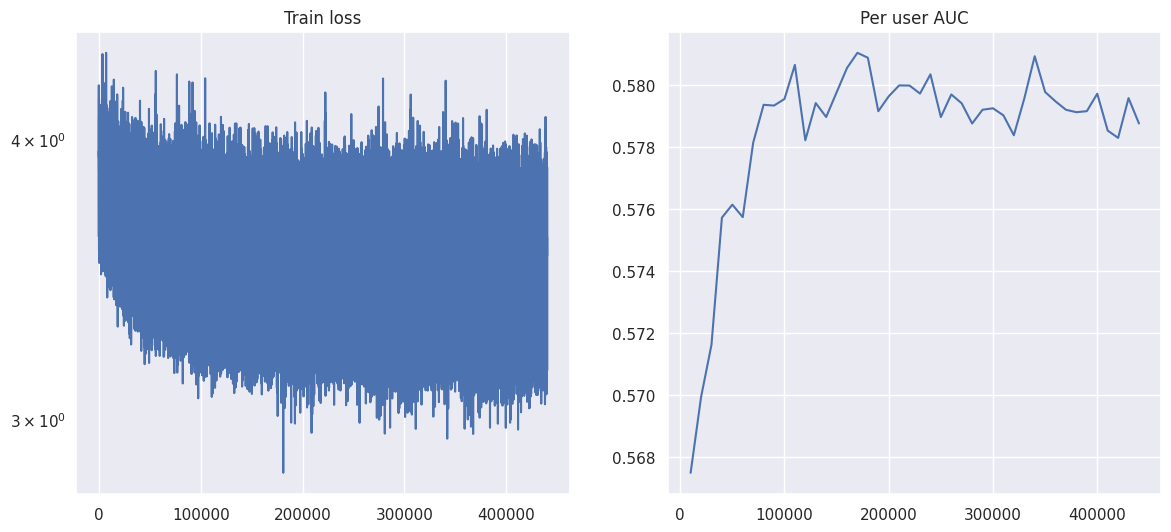

Epoch 4:  97%|█████████▋| 87963/90507 [31:36<00:29, 85.77it/s]

  0%|          | 0/75910 [00:00<?, ?it/s]

Epoch 4: 100%|██████████| 90507/90507 [33:59<00:00, 44.39it/s]


In [ ]:
train(model, optimizer, train_loader)

In [ ]:
user_embeddings, item_embeddings = get_embeddings(users_monobatch, items_monobatch)
auc = calculate_per_user_auc(user_embeddings, item_embeddings, user_ratings, 'testRatings')

  0%|          | 0/75910 [00:00<?, ?it/s]

In [ ]:
print('Test ROC-AUC:', auc)

Test ROC-AUC: 0.5803498991940542


In [ ]:
torch.save(model.state_dict(), 'dssm.pt')
np.save('user_embeddings.npy', user_embeddings)
np.save('item_embeddings.npy', item_embeddings)

In [ ]:
!cp dssm.pt drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/dssm.pt
!cp user_embeddings.npy drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/user_embeddings.npy
!cp item_embeddings.npy drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/item_embeddings.npy

Тут можно написать интересные замечания и выводы по модели и ее обучению.

**Выводы:**

* В итоговом варианте DICT_SIZE=5к, при большем значении 10+к качество менялось незначительно, возможно было бы лучше качественнее предобработать тексты: убрать спецсимволы, иероглифы, нормализовать слова и т.д.
* Без нормировки на $1 / \sqrt{\text{количество токенов}}$ модель учится хуже, причем с нормировкой $1 / (\text{количество токенов})$ качество тоже пониже, т.е. численная нестабильность здесь важный момент.
* ROC-AUC выходит на ~плато за 2 эпохи, было бы лучше настроить расписание learning rate (например, Cosine Annealing with Warmup)

---

# Часть 2. Ранжирующая модель



Классический пайплайн рекомендаций выглядит следующим образом:

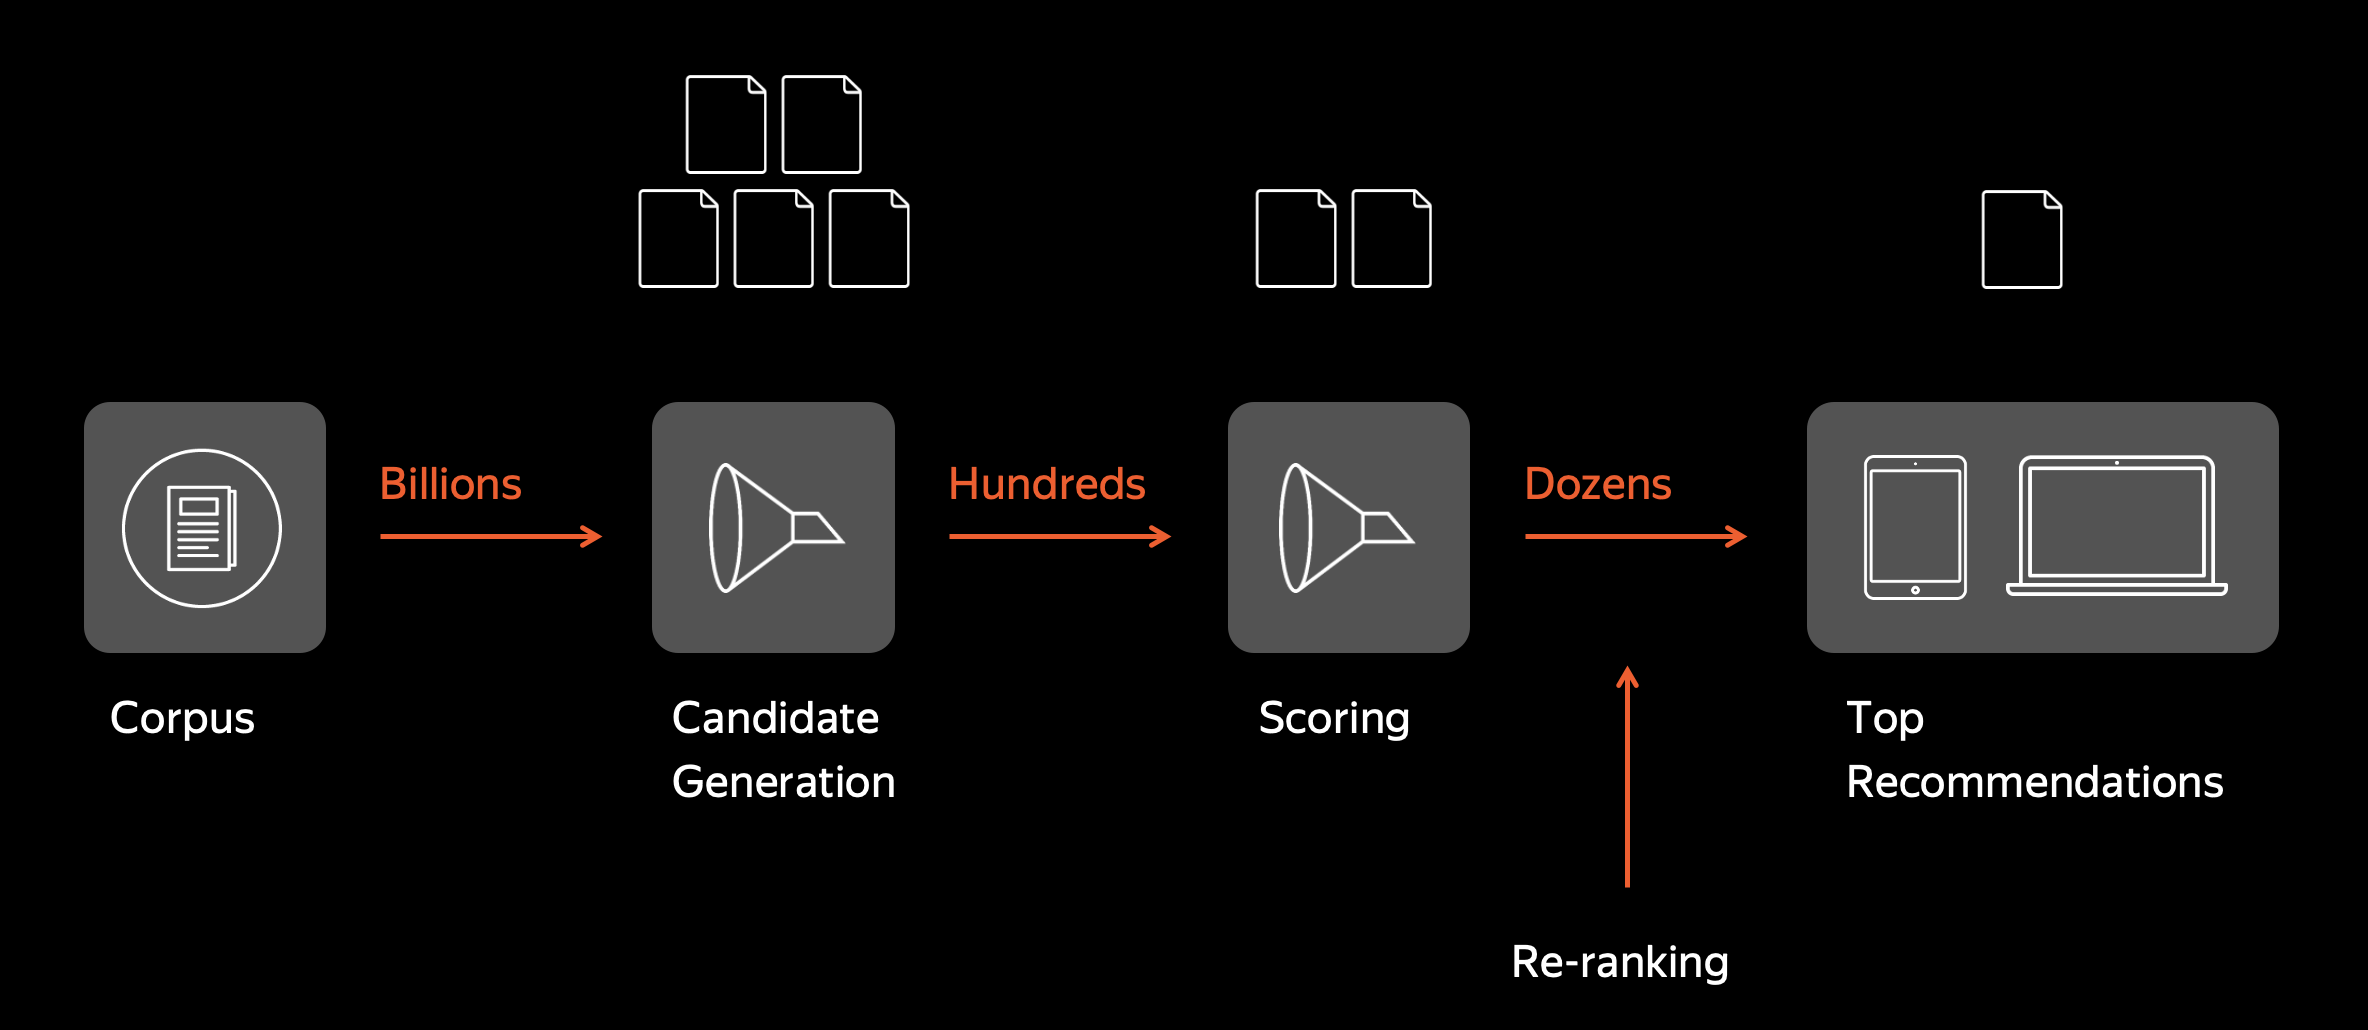

* Отбор кандидатов. Сначала из всей базы документов отбирается некоторое количество кандидатов. Это нужно, потому что в реальном сервисе очень большое количество документов и невозможно на каждый запрос отскорить всё. В качестве "селекторов" могут выступать простые с вычислительной точки зрения модели (например, kNN по эмбеддингам, предсказание FM, SLIM).
* Ранжирующая модель. Отобранные на предыдущем шаге айтемы ранжируются моделью, чтобы отобрать топ документов для пользователя.
* Затем айтемы дополнительно переранжируются с учетом бизнес-логики.

Более подробно этот пайплайн обсуждался на лекции 1.

В этом задании вам предстоит построить и обучить ранжирующую модель на датасете Дзена.

В качестве самой модели применяют модели на основе градиентного бустинга, в данном задании предлагается использовать CatBoost. В качестве фичей модели используем
* Скалярное произведение, косинусное расстояние между пользовательским и айтемным эмбеддингами. Эмбеддинги: *explicit ALS*, *implicit ALS*, *DSSM*.
* Айтемные и пользовательские статистики (ctr, количество показов и т.п.)

### Создание датасета

In [210]:
import random

def create_dataset(user_ratings, ratings_column, user_encoder, features_getters=None, probability_sample_zero=0.1):
    """
    Датасет из пар user-item, их фичей и меток позитивных/негативных взаимодействий
    Также c указание группы, объединяющей взаимодействия одного юзера
    В user_ratings ~5 млн полож. взаимодействий и ~50 млн отриц -> сэмплируем долю отриц. (probability_sample_zero)
    * Если features_getters не задан, создается датасет только с юзерами/айтемами и оценками (для ALS/IALS)
    * Если features_getters задан, то создается датасет с фичами dot/cos из эмбеддингов (для Catboost)
    """
    users = []
    items = []
    labels = []
    group_ids = []
    user_ids = user_encoder.transform(user_ratings['userId'])
    items_no_positives = list(train_dataset.items_without_positive_interactions)

    if features_getters:
        features = {f'dot_{k}': [] for k in range(len(features_getters))} | \
                  {f'cos_{k}': [] for k in range(len(features_getters))}
    else:
        features = {}

    for i, (user_id, items_with_ratings) in notebook.tqdm(enumerate(zip(user_ids, user_ratings[ratings_column])),
                                                          total=len(user_ids)):
        # Проход по айтемам юзера
        user_items_ids = []
        last_item = None
        has_positive_flag = False
        for itemId, rating in parse_ratings_history(items_with_ratings).items():
            item_id = item_to_id[itemId]
            if rating == 1:
                has_positive_flag = True
                user_items_ids.append(item_id)
                users.append(user_id)
                items.append(item_id)
                labels.append(1)
                group_ids.append(i)
            else:
                # Сэмплируем случайную долю негативных взаимодействий для train'а, для test'а берем все
                if ('test' in ratings_column) or (random.uniform(0,1) < probability_sample_zero):
                    user_items_ids.append(item_id)
                    users.append(user_id)
                    items.append(item_id)
                    labels.append(0)
                    group_ids.append(i)
            last_item = item_id

        if 'train' in ratings_column:
            # Обработка юзера, если случайно остался без айтема или нет позитивов
            if (len(user_items_ids) == 0) or (not has_positive_flag):
                print(f'INFO: user {user_id} (without positives) by random has no items at all, added the last item')
                user_items_ids.append(item_id)
                users.append(user_id)
                items.append(last_item)
                labels.append(1)
                group_ids.append(i)

            # Обработка айтемов без позитивных воздействий: для IALS требуется хотя бы один фидбек
            try:
                item_to_add = items_no_positives.pop(0)
                user_items_ids.append(item_to_add)
                users.append(user_id)
                items.append(item_to_add)
                labels.append(1)
                group_ids.append(i)
            except IndexError:
                pass

        if features_getters:
            # Получаем фичи для сэмплированного набора айтемов юзера
            for j, fg in enumerate(features_getters):
                dot, cos = fg.get_features(user_id, user_items_ids)
                features[f'dot_{j}'] += list(dot)
                features[f'cos_{j}'] += list(cos)
        
    # Собираем датасет
    dataset = pd.DataFrame({'user': users, 
                            'item': items, 
                            **features,
                            'label': labels,
                            'group_id': group_ids})
    return dataset

In [196]:
%%time
als_train = create_dataset(user_ratings, 'trainRatings', user_encoder)
print(f'Train shape: {als_train.shape}')

  0%|          | 0/75910 [00:00<?, ?it/s]

INFO: user 57518 (without positives) by random has no items at all, added the last item
INFO: user 1031 (without positives) by random has no items at all, added the last item
INFO: user 31022 (without positives) by random has no items at all, added the last item
INFO: user 55525 (without positives) by random has no items at all, added the last item
INFO: user 4943 (without positives) by random has no items at all, added the last item
Train shape: (9438186, 4)
CPU times: user 1min 32s, sys: 1.29 s, total: 1min 33s
Wall time: 1min 33s


In [197]:
display(als_train.head(2))
display(als_train.tail(2))

,user,item,label,group_id
0,37842,59758,0,0
1,37842,47238,0,0


,user,item,label,group_id
9438184,51853,95071,1,75909
9438185,51853,37172,0,75909


## ALS, IALS, DSSM embeddings

Обучите explicit и implicit ALS.  
Можете использовать, как свою реализацию из первого задания, так и реализации из публичных библиотек (Implicit, Lightfm, Surprise, LensKit, etc.) 

In [124]:
!pip install lenskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 14.0 MB/s eta 0:00:00


In [198]:
from lenskit.algorithms.als import BiasedMF, ImplicitMF

DIMENSION = 10

**ALS (Explicit ALS)**

In [199]:
eals = BiasedMF(features=DIMENSION, 
                iterations=30, 
                reg=0.2,
                method='cd') # Coordinate descent

In [200]:
%%time
eals.fit(als_train[['user', 'item', 'label']].rename(columns={'label': 'rating'}))

CPU times: user 1min 38s, sys: 1min 41s, total: 3min 20s
Wall time: 24.2 s


In [201]:
eals_user_embeddings, eals_item_embeddings = eals.user_features_, eals.item_features_
print(eals_user_embeddings.shape, eals_item_embeddings.shape)

(75910, 10) (104503, 10)


**IALS (Implicit ALS)** 

In [202]:
ials = ImplicitMF(features=DIMENSION, 
                  iterations=30, 
                  reg=0.2,
                  method='cg') # Conjugate gradient

In [203]:
%%time
ials.fit(als_train.loc[als_train['label'] == 1][['user', 'item']])

CPU times: user 6min 21s, sys: 3min 37s, total: 9min 58s
Wall time: 53.2 s


In [204]:
ials_user_embeddings, ials_item_embeddings = ials.user_features_, ials.item_features_
print(ials_user_embeddings.shape, ials_item_embeddings.shape)

(75910, 10) (104503, 10)


**DSSM**

In [17]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/user_embeddings.npy user_embeddings.npy
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/RecSys/HW2/item_embeddings.npy item_embeddings.npy

dssm_user_embeddings, dssm_item_embeddings = np.load('user_embeddings.npy'), np.load('item_embeddings.npy')
print(dssm_user_embeddings.shape, dssm_item_embeddings.shape)

(75910, 10) (104503, 10)


## Catboost

Построим эмбеддинговые признаки пары пользователь-айтем.

In [205]:
from sklearn.metrics.pairwise import cosine_similarity

class EmbeddingFeatureGetter:
    def __init__(self, user_embeddings, item_embeddings):
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings
    
    def get_features(self, user_id, item_ids):
        """
        * user_id -- индекс пользователя для построения признаков
        * item_ids -- список индексов айтемов
        Return:
        * dot, cos -- у обоих shape = (len(item_ids),)
        """
        user_emb = self.user_embeddings[user_id]
        items_embs = self.item_embeddings[item_ids]
        dot = user_emb @ items_embs.T
        cos = cosine_similarity(user_emb.reshape(-1, 1).T, items_embs).reshape(-1)
        return dot, cos

In [206]:
eals_features_getter = EmbeddingFeatureGetter(eals_user_embeddings, eals_item_embeddings)
ials_features_getter = EmbeddingFeatureGetter(ials_user_embeddings, ials_item_embeddings)
dssm_features_getter = EmbeddingFeatureGetter(dssm_user_embeddings, dssm_item_embeddings)

Построим айтемные и пользовательские признаки.

In [207]:
%%time
catboost_train = create_dataset(user_ratings, 'trainRatings', user_encoder, 
                                [eals_features_getter, ials_features_getter, dssm_features_getter])
print(f'Train shape: {catboost_train.shape}')

  0%|          | 0/75910 [00:00<?, ?it/s]

INFO: user 57518 (without positives) by random has no items at all, added the last item
INFO: user 1031 (without positives) by random has no items at all, added the last item
INFO: user 31022 (without positives) by random has no items at all, added the last item
INFO: user 55525 (without positives) by random has no items at all, added the last item
INFO: user 4943 (without positives) by random has no items at all, added the last item
Train shape: (9436187, 10)
CPU times: user 3min 19s, sys: 10.7 s, total: 3min 30s
Wall time: 3min 22s


In [208]:
display(catboost_train.head(2))
display(catboost_train.tail(2))

,user,item,dot_0,dot_1,dot_2,cos_0,cos_1,cos_2,label,group_id
0,37842,62828,-2.483984e-15,0.245560,0.000375,-1.0,0.524629,0.448082,1,0
1,37842,84236,2.479199e-14,0.387571,0.000448,1.0,0.576176,0.455621,1,0


,user,item,dot_0,dot_1,dot_2,cos_0,cos_1,cos_2,label,group_id
9436185,51853,42542,-3.180864e-16,0.136295,0.001728,-1.000000,0.114466,0.189588,1,75909
9436186,51853,95071,-2.628760e-17,0.759168,0.000753,-0.999999,0.152141,0.105023,1,75909


In [211]:
catboost_test = create_dataset(user_ratings, 'testRatings', user_encoder, 
                               [eals_features_getter, ials_features_getter, dssm_features_getter])
print(f'Test shape: {catboost_test.shape}')

  0%|          | 0/75910 [00:00<?, ?it/s]

Test shape: (9324073, 10)


In [212]:
features = [col for col in catboost_train.columns if ('dot' in col) or ('cos' in col)]
print(f'Features: {features}')

Features: ['dot_0', 'dot_1', 'dot_2', 'cos_0', 'cos_1', 'cos_2']


Для построения модели catboost будем пользоваться одноименной [библиотекой](https://catboost.ai/en/docs/concepts/python-reference_catboost). Для обучения модели удобно использовать интерфейс библиотеки, с использованием представления данных `Pool`.

In [53]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 16.5 MB/s eta 0:00:00


In [213]:
import catboost

In [214]:
train_features = catboost_train[features].to_numpy()
train_labels = catboost_train['label'].to_numpy()
train_group_ids = catboost_train['group_id'].to_numpy()

In [215]:
train_pool = catboost.Pool(train_features, train_labels, group_id=train_group_ids)

In [216]:
test_features = catboost_test[features].to_numpy()
test_labels = catboost_test['label'].to_numpy()
test_group_ids = catboost_test['group_id'].to_numpy()

In [217]:
test_pool = catboost.Pool(test_features, test_labels, group_id=test_group_ids)

Обучим саму модель. В [документации](https://catboost.ai/en/docs/references/training-parameters/common#loss_function) есть описание того, как передавать лосс, и какие функции возможны.

Попробуйте обучить на лосс бинарной классификации и ранжирования (второе стоит учить с маленьким числом генерируемых пар на `group_id` во избежание вычислительных трудностей).

__CatBoost: Binary classification__

In [218]:
cb = catboost.CatBoost({'objective': 'Logloss', 
                        'eval_metric': 'AUC',
                        'n_estimators': 200,
                        'random_seed': 0})

In [219]:
cb.fit(train_pool, eval_set=test_pool, verbose=50)

Learning rate set to 0.5
0:	test: 0.6224574	best: 0.6224574 (0)	total: 889ms	remaining: 2m 56s
50:	test: 0.6269194	best: 0.6276609 (7)	total: 51s	remaining: 2m 29s
100:	test: 0.6267136	best: 0.6276609 (7)	total: 1m 45s	remaining: 1m 42s
150:	test: 0.6265419	best: 0.6276609 (7)	total: 2m 35s	remaining: 50.3s
199:	test: 0.6263775	best: 0.6276609 (7)	total: 3m 23s	remaining: 0us

bestTest = 0.6276608646
bestIteration = 7

Shrink model to first 8 iterations.


In [220]:
predictions_binary = cb.predict(test_pool, prediction_type='Probability')[:, 1]
binary_df = pd.DataFrame({'user': catboost_test['user'], 
                          'y_score': predictions_binary})
# user -> predictions
per_user_predictions_binary = binary_df.groupby('user')['y_score'].apply(list).to_dict()

__CatBoost: Learning to rank__

In [221]:
cb_ranking = catboost.CatBoost({'objective': 'PairLogit:max_pairs=10', 
                                'eval_metric': 'NDCG',
                                'n_estimators': 200,
                                'random_seed': 0})

In [222]:
cb_ranking.fit(train_pool, eval_set=test_pool, verbose=50)

0:	test: 0.5190106	best: 0.5190106 (0)	total: 1.89s	remaining: 6m 15s
50:	test: 0.5733754	best: 0.5733754 (50)	total: 1m 37s	remaining: 4m 43s
100:	test: 0.5740637	best: 0.5740820 (99)	total: 3m 11s	remaining: 3m 7s
150:	test: 0.5740335	best: 0.5740991 (108)	total: 4m 43s	remaining: 1m 32s
199:	test: 0.5740085	best: 0.5740991 (108)	total: 6m 19s	remaining: 0us

bestTest = 0.574099096
bestIteration = 108

Shrink model to first 109 iterations.


In [223]:
predictions_ranking = cb_ranking.predict(test_pool, prediction_type='Probability')[:, 1]
ranking_df = pd.DataFrame({'user': catboost_test['user'], 
                          'y_score': predictions_ranking})
# user -> predictions
per_user_predictions_ranking = ranking_df.groupby('user')['y_score'].apply(list).to_dict()

Оценим качество

In [224]:
def calculate_per_user_auc(user_ratings, per_user_predictions, column):
    aucs = []
    user_ids = user_encoder.transform(user_ratings['userId'])
    
    for user_id, item_ratings in notebook.tqdm(zip(user_ids, user_ratings[column]), total=len(user_ids)):
        item_ids, item_ratings = zip(*parse_ratings_history(item_ratings).items())
        if len(set(item_ratings)) == 1:
            continue
        item_ids = [item_to_id[item_id] for item_id in item_ids]
        scores = per_user_predictions[user_id]
        roc_auc = roc_auc_score(item_ratings, scores)
        aucs.append(roc_auc)
        
    return aucs

In [225]:
per_user_auc_binary = calculate_per_user_auc(user_ratings, per_user_predictions_binary, 'testRatings')
print(f'LogLoss: AUC =', np.mean(per_user_auc_binary))

  0%|          | 0/75910 [00:00<?, ?it/s]

LogLoss: AUC = 0.5983462840102243


In [226]:
per_user_auc_ranking = calculate_per_user_auc(user_ratings, per_user_predictions_ranking, 'testRatings')
print(f'PairLogit: AUC =', np.mean(per_user_auc_ranking))

  0%|          | 0/75910 [00:00<?, ?it/s]

PairLogit: AUC = 0.6009087372598617


**Выводы:**

* В обычном DSSM качество **ROC-AUC = 0.580**, с комбинацией фич из ALS/IALS/DSSM и Catboost поверх получилось достичь **0.598** и **0.601** соответственное для LogLoss и PairLogit
* Как видим, имея предпосчитанные качественные фичи, например, эмбеддинги и их dot/cos/.., обучить и применить модель ранкинга получается достаточно быстро и эффективно
* Лучшего качества можно добиться, сгенерировав user/item-specific фичи, добавив CTR, показы и т.д.
* Также можно попробовать потюнить параметры всех четырех моделей - ALS/IALS/DSSM/Catboost, или применить другой лосс для ранкинга Catboost'а